# PyTorch Toolkit: 01 - Linear Regression

This notebook is the first entry in a series exploring PyTorch for deep learning. Here, we build the most basic model: a simple linear regression model.

**Goal:** To predict a numerical value based on a single input feature. We will:
1.  Create synthetic data with a linear relationship.
2.  Define two versions of a linear regression model, a 'manual' and an 'abstraction' approach.
3.  Train the model using a loss function and an optimizer.
4.  Evaluate the results and visualize the predictions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
torch.__version__

'2.9.0+cpu'

## 1. Data preparation
We'll start by creating some synthetic "known" data, so we can see how well our model learns the true underlying parameters (`weight` and `bias`) that we define ourselves.

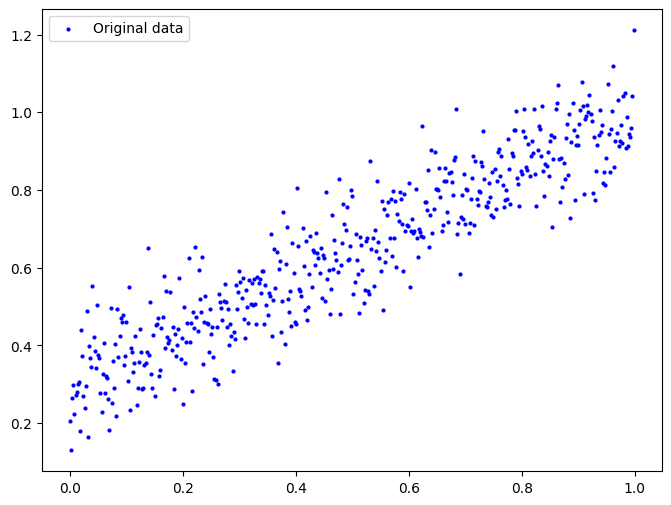

In [11]:
# Create known parameters (the model will try to learn these)
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.002
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias + torch.randn(X.shape) * 0.08 # Add some noise

# Plot to see the linear relationship
def plot_data(X_data, y_data, predictions=None):
    plt.figure(figsize=(8,6))
    plt.scatter(X_data, y_data, c='b', s=4, label='Original data')
    if predictions is not None:
        plt.scatter(X_data, predictions, c='r', s=4, label='Predictions')
    plt.legend()
    plt.show()

plot_data(X, y)

## 2. Model architecture
We will define our model in two ways to understand what PyTorch does behind the scenes.

### 2.1 Manual implementation (using `nn.Parameter`)
We manually define the `weights` and `bias` as trainable parameters by wrapping them in `nn.Parameter`. This tells PyTorch to track gradients for these specific tensors during training.

In [4]:
class LinearRegressionModelManual(nn.Module):
    def __init__(self):
        super().__init__()
        # Explicitly create trainable parameters
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is the input data
        # Perform the computation (linear equation)
        return self.weights * x + self.bias

### 2.2 Idiomatic PyTorch implementation (using `nn.Linear`)
While the manual approach is great for learning, the standard way to build models in PyTorch is by using its library of pre-built layers. 

The `nn.Linear` layer does the exact same thing as our manual implementation but in a more concise and scalable way.

In [5]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pre-built layer that contains the weights and biases internally
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Call the layer, which applies the ecuation
        return self.linear_layer(x)

 ## 3. Training the model

 

### 3.1 Setup: Loss Function and Optimizer
Before we train, we need to specify:
- **Loss Function:** To measure how wrong our model's predictions are. We'll use `nn.L1Loss` (Mean absolute error).
- **Optimizer:** To adjust our model's parameters to reduce the loss. We'll use `torch.optim.SGD` (Stochastic gradient descent).
- **Learning Rate:** To control how much the model's parameters are updated during training.

In [6]:
torch.manual_seed(42)
model = LinearRegressionModel()

# Loss function
loss_fn = nn.L1Loss()

# Optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

### 3.2 The training loop
This is the core of the process. We will loop over the data for a set number of *epochs*, and in each loop, we will perform the five essential steps of training a PyTorch model.

1. Forward pass: pass the data through the model to get predictions
2. Calculate loss: compare the predictions with the actual values
3. Reset the gradients of the model parameters (so they don't accumulate)
4. Backprop step: perform backpropagation on the loss with respect to the parameters of the model
5. Optimizer step: optimizer updates the parameters using the gradients calculated in the previous step


In [7]:
epochs = 1_000

# Train-test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Training loop
for epoch in range(epochs):
    # Put the model in training mode
    model.train()
    
    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Reset the gradients of the model parameters
    optimizer.zero_grad()

    # 4. Backprop step
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    # Testing (to check what it's going on)
    model.eval() # Set the model in evaluation mode
    with torch.no_grad(): # Disable gradient tracking
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Test loss: {test_loss:.4f}")
        print(f"Model parameters: {model.state_dict()}")
        print("-" * 30)

    # We can save the model's state_dict to make predictions later
    PATH = "../../models/linear_regression_model.pth"
    torch.save(obj=model.state_dict(), f=PATH)


Epoch: 0 | Loss: 0.5543 | Test loss: 0.5774
Model parameters: OrderedDict({'linear_layer.weight': tensor([[0.7605]]), 'linear_layer.bias': tensor([0.8200])})
------------------------------
Epoch: 50 | Loss: 0.0700 | Test loss: 0.0595
Model parameters: OrderedDict({'linear_layer.weight': tensor([[0.5890]]), 'linear_layer.bias': tensor([0.3774])})
------------------------------
Epoch: 100 | Loss: 0.0650 | Test loss: 0.0651
Model parameters: OrderedDict({'linear_layer.weight': tensor([[0.6039]]), 'linear_layer.bias': tensor([0.3460])})
------------------------------
Epoch: 150 | Loss: 0.0640 | Test loss: 0.0621
Model parameters: OrderedDict({'linear_layer.weight': tensor([[0.6233]]), 'linear_layer.bias': tensor([0.3367])})
------------------------------
Epoch: 200 | Loss: 0.0635 | Test loss: 0.0601
Model parameters: OrderedDict({'linear_layer.weight': tensor([[0.6386]]), 'linear_layer.bias': tensor([0.3297])})
------------------------------
Epoch: 250 | Loss: 0.0631 | Test loss: 0.0588
Mo

## 4. Evaluation and visualization
Now that the model is trained, let's see how well it learned the relationship in our data by plotting its predictions against the actual test data.

Final model parameters:
OrderedDict({'linear_layer.weight': tensor([[0.7000]]), 'linear_layer.bias': tensor([0.3040])})


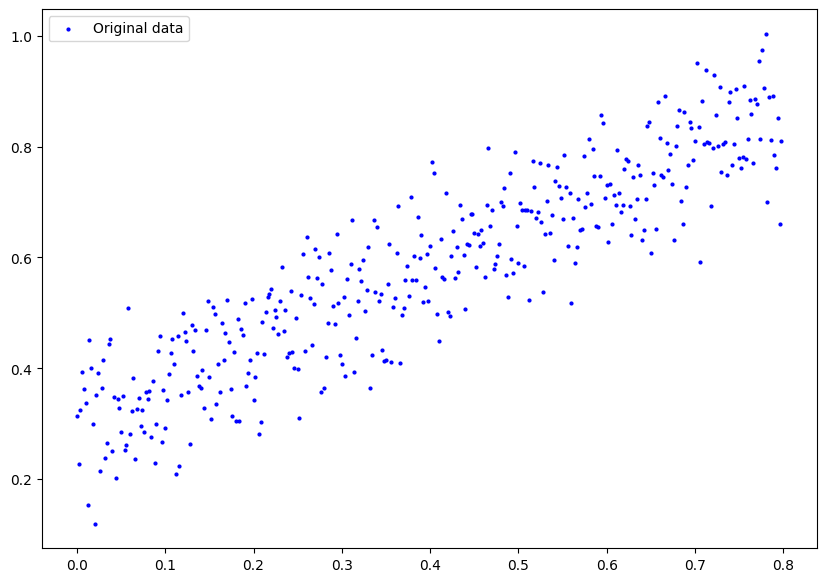

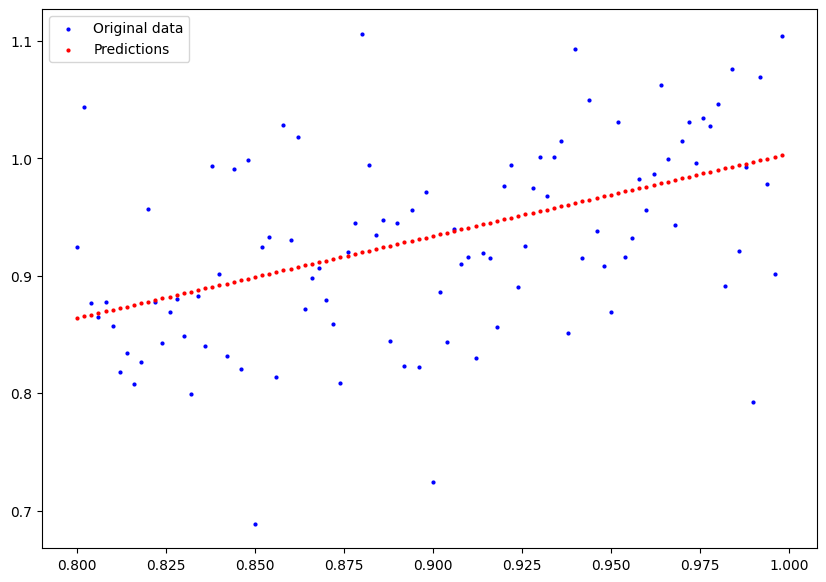

In [8]:
# Put the model in evaluation mode
model.eval()

# Make predictions with the trained model
with torch.no_grad():
    y_preds_new = model(X_test)

# You can see the final learned parameters
print("Final model parameters:")
print(model.state_dict())

# Plot the results
plot_data(X_train, y_train, predictions=None) # Plot original training data
plot_data(X_test, y_test, predictions=y_preds_new) # Plot test data and predictions


## 5. Summary

The model successfully learned the linear relationship in the data, and the parameters are very close to the original ones.

- **Original parameters:** `weight=0.7`, `bias=0.3`
- **Learned parameters:** `weight=0.6933`, `bias=0.2964`